In [6]:
# run this cell to get the merged_rnn csv file

# import pandas as pd
# import numpy as np

# merged_path = '../data/plank_Chesapeake_buoywater_merged.csv'
# data = pd.read_csv(merged_path)

# # merge columns from two datasets - they do not overlap
# data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
# data = data.drop(columns=['Chlorophyll','CHLA'])
# data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

# data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
# data = data.drop(columns=['Salinity','SALINITY'])
# data = data.rename(columns={'Salinity_Merged': 'Salinity'})

# data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
# data = data.drop(columns=['Temperature','WTEMP'])
# data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

# data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
# data = data.drop(columns=['Oxygen','DO'])
# data = data.rename(columns={'DO_Merged': 'Oxygen'})

# data.to_csv('../data/plank_Chesapeake_buoywater_merged_rnn.csv', index=False)

Notes:
1. simple imputation techniques (mean, linear regression) are not too helpful
2. main issue is with a large percentage of missing data for certain columns ( > 95%)
    - the columns are important predictors and can't be removed
    - try to work with coarser datasets by looking at daily averages
3.  See https://kearnz.github.io/autoimpute-tutorials/ for autoimpute

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from autoimpute.imputations import MiceImputer, SingleImputer, MultipleImputer
from autoimpute.visuals import plot_md_locations, plot_md_percent

2024-09-07 04:38:06.869679: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 04:38:06.871933: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 04:38:06.949116: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 04:38:07.272008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 04:38:09.055900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [14]:
# Load the dataset
merged_path = '../data/plank_Chesapeake_buoywater_merged_rnn.csv'
data = pd.read_csv(merged_path)

In [15]:
# create time column from sample_year, sample_month, sample_day, sample_hour, sample_minute, sample_second
data['Time'] = pd.to_datetime(dict(year=data.Sample_year,month= data.Sample_month,day=data.Sample_day,hour=data.Sample_hour,minute=data.Sample_minute,second=data.Sample_second))

In [16]:
# drop columns that are not needed for now (currents have extreme values, sample_* are reindexed as datetime)
# might drop more after test run)
data = data.drop(columns=['North surface currents','East surface currents','Sample_year', 'Sample_month', 'Sample_day','Sample_hour', 'Sample_minute', 'Sample_second','Wave period','Latitude','Longitude'])

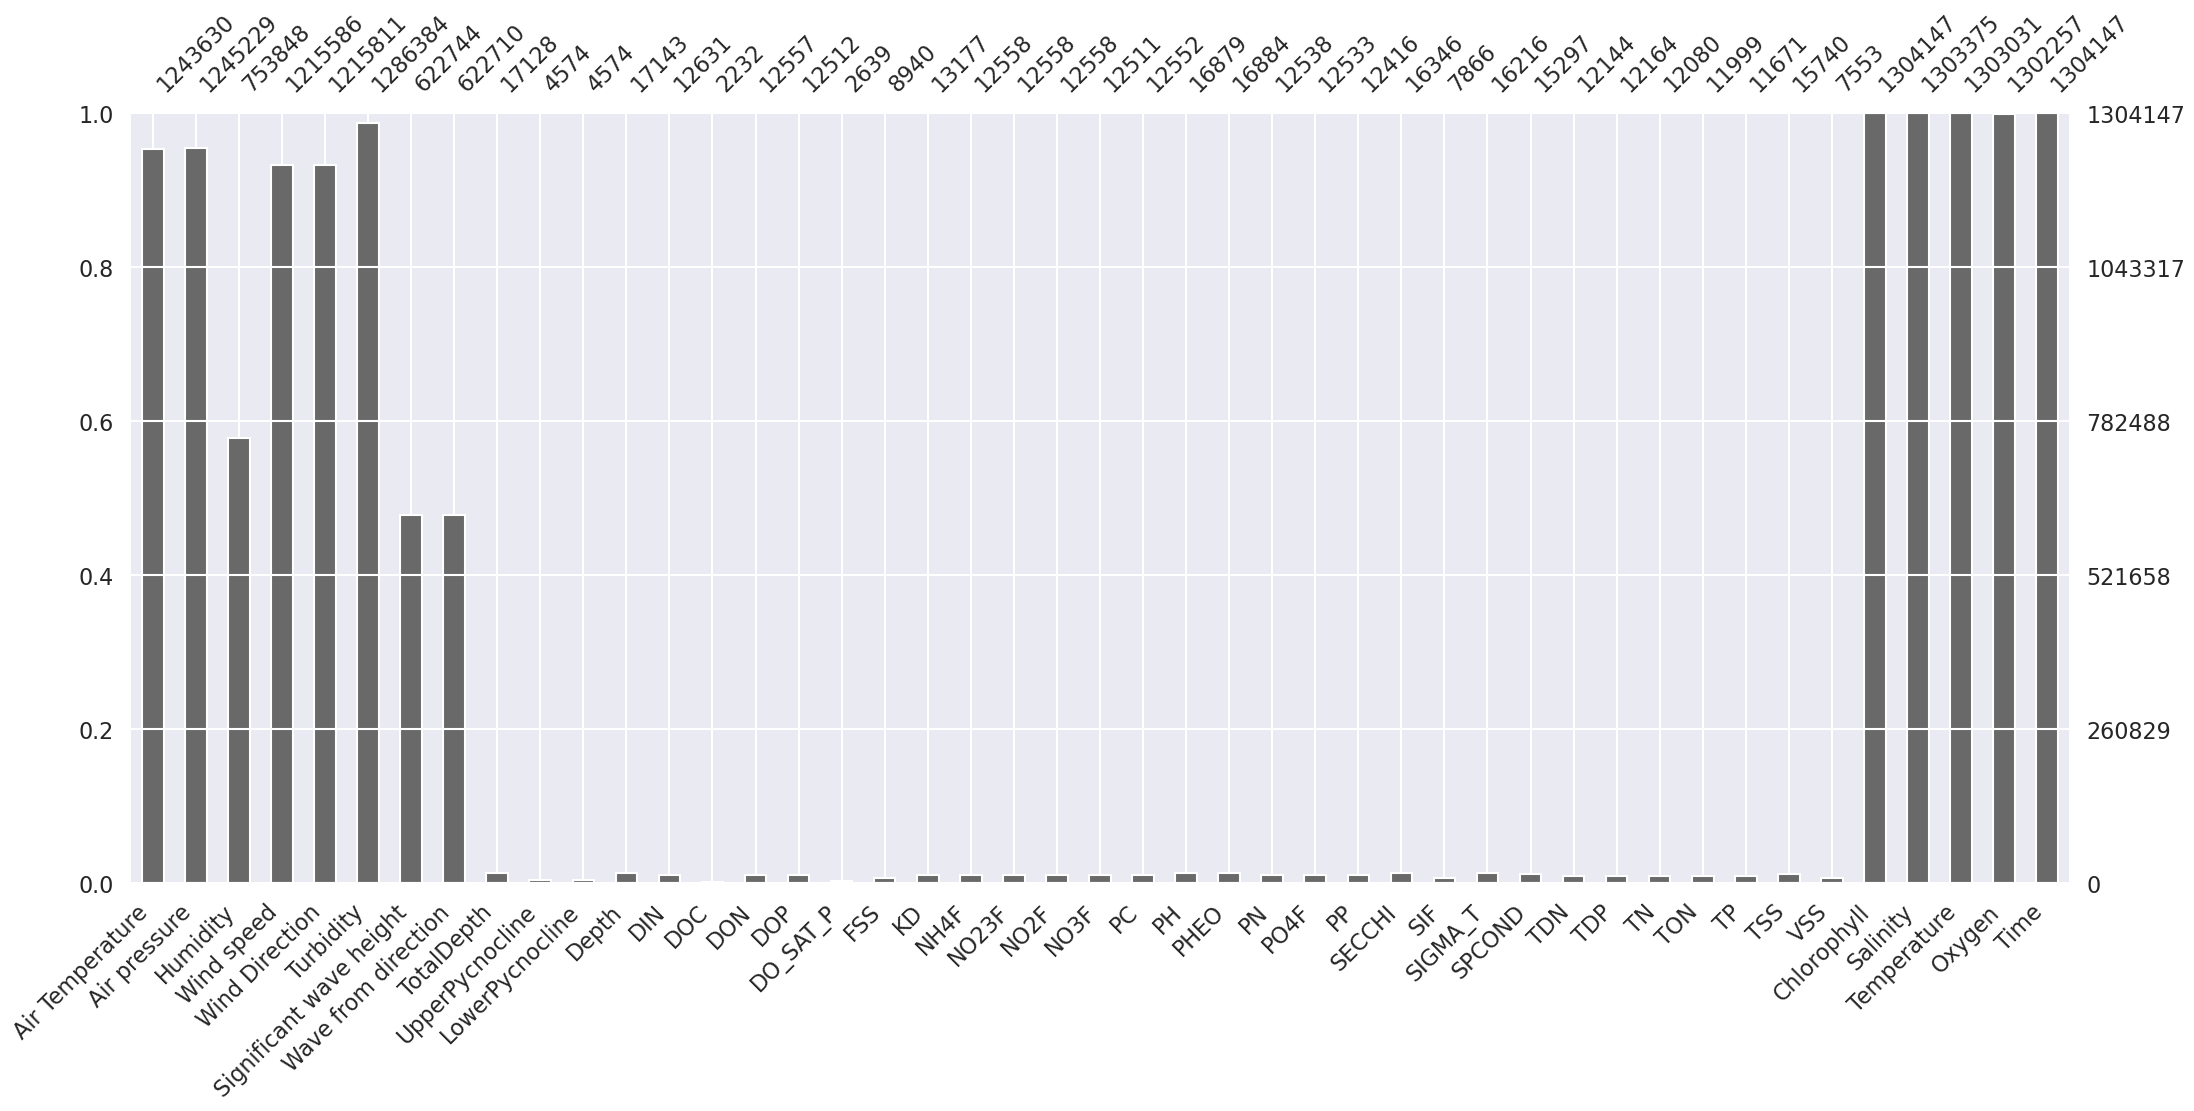

In [17]:
plot_md_percent(data)

In [18]:
# can't use the data as is, need to resample to hourly data
data = data.resample('h',on='Time').mean().dropna(how='all')

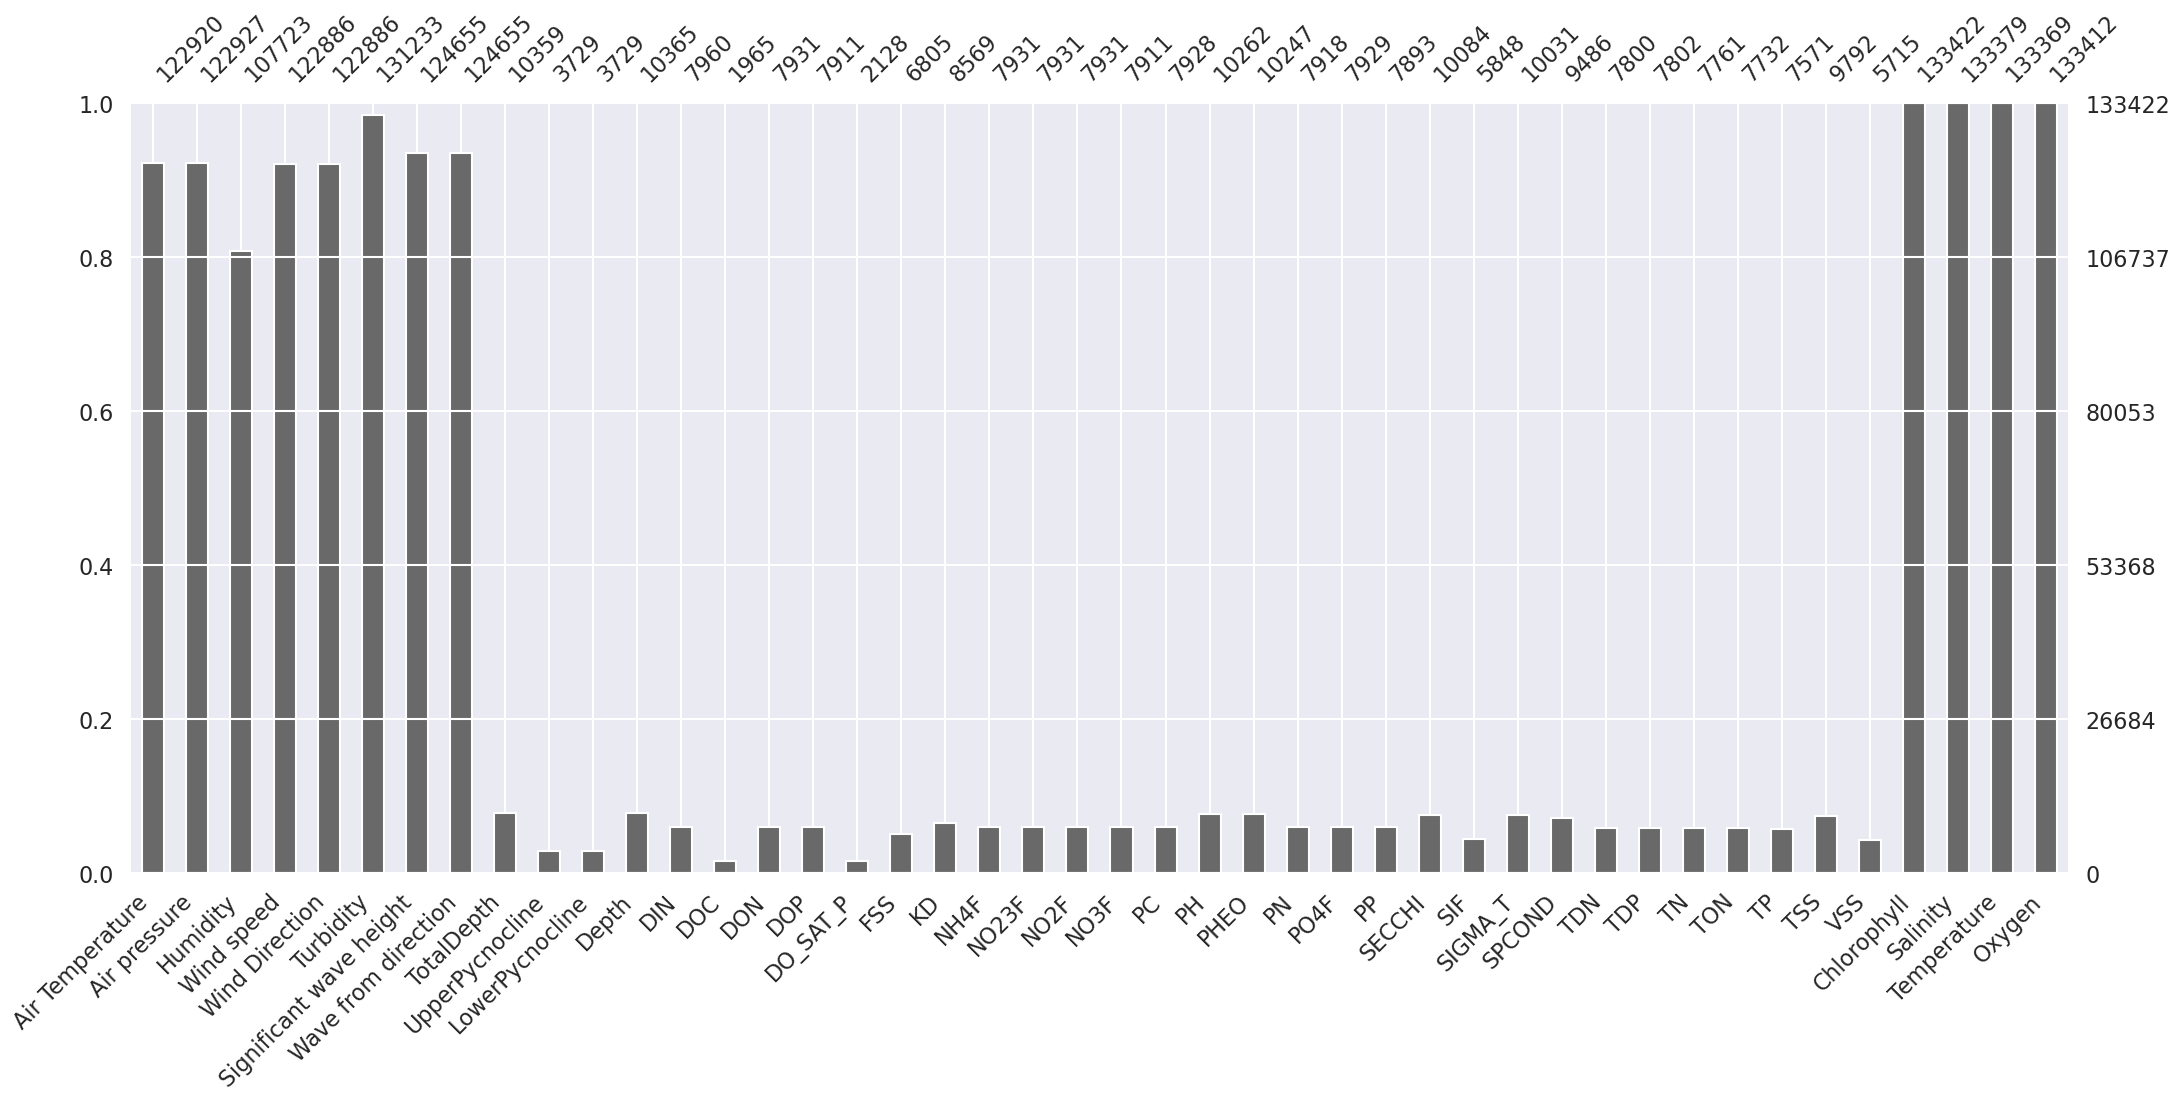

In [19]:
plot_md_percent(data)

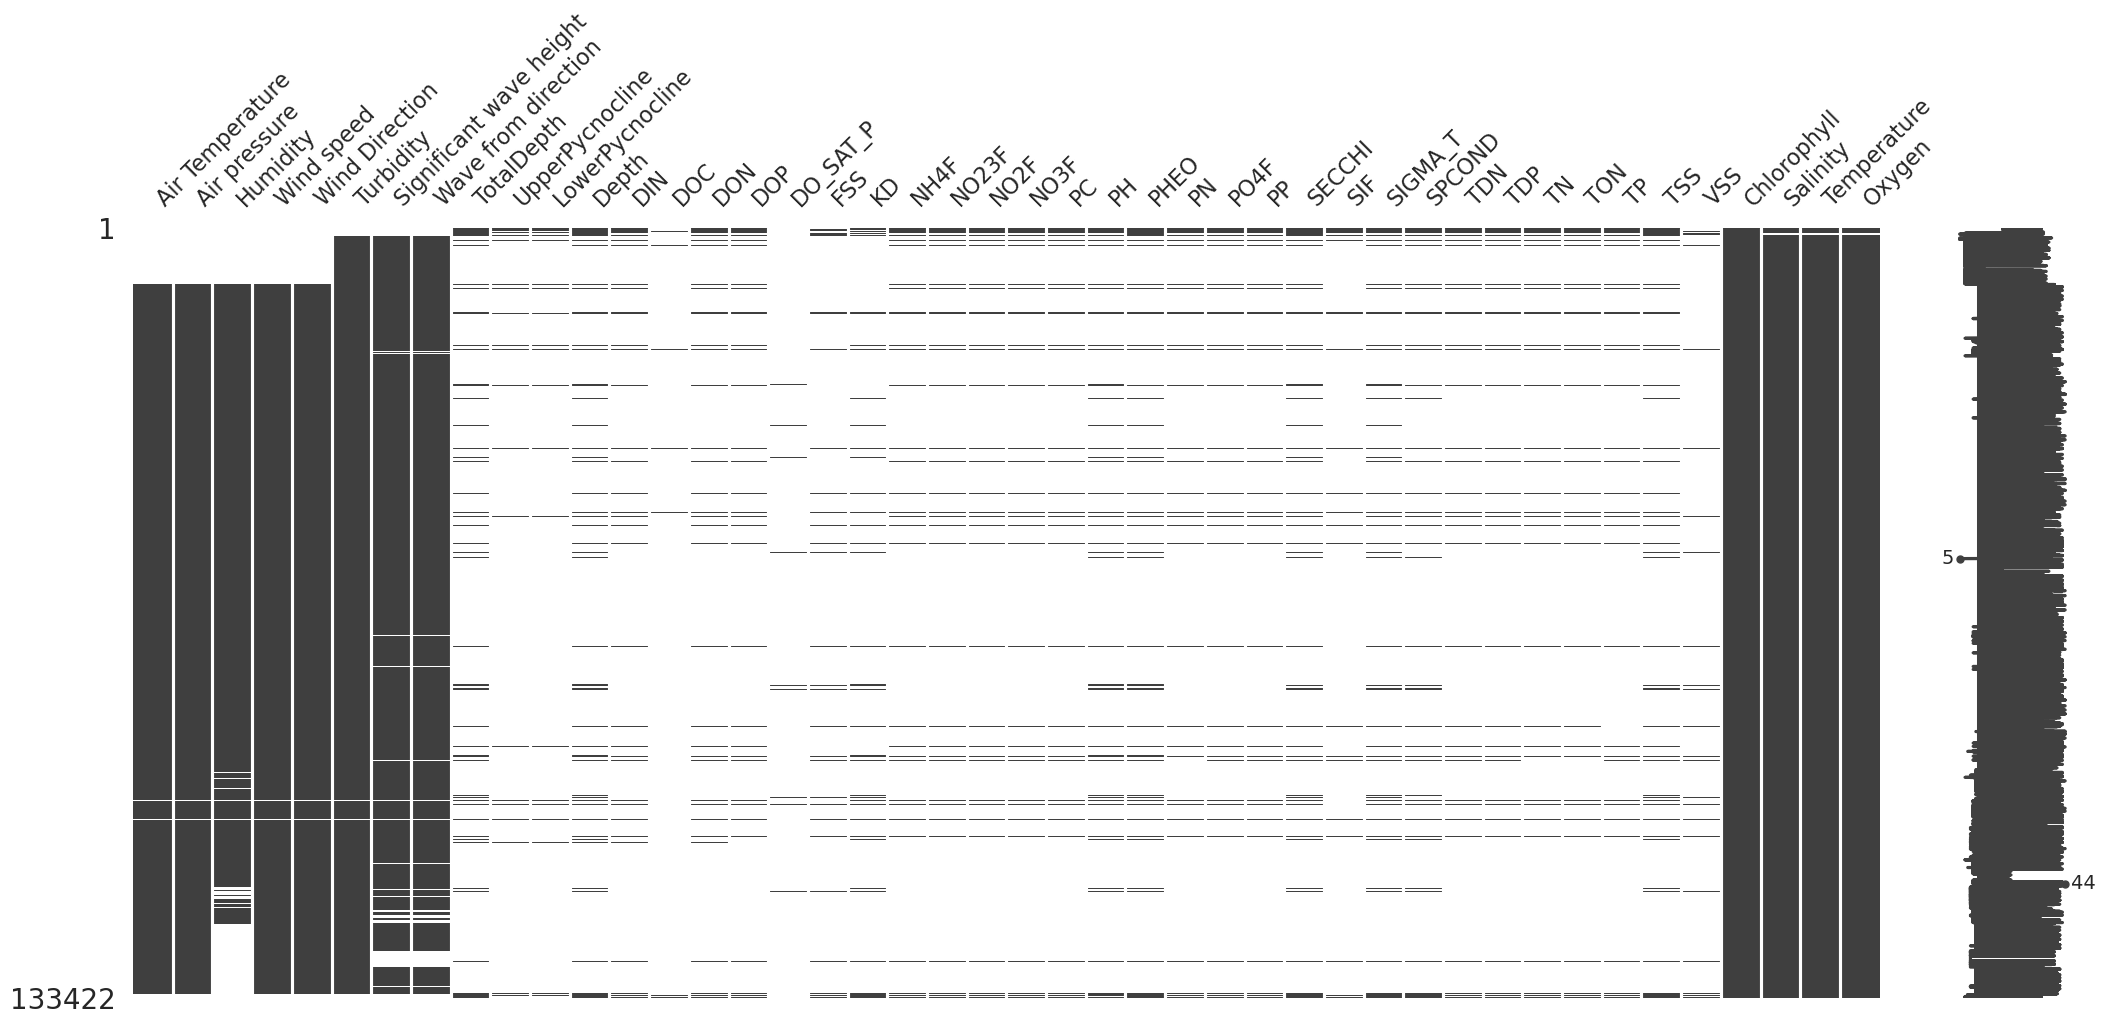

In [20]:
plot_md_locations(data)

In [38]:
# running into divergence issues with pmm
# strategy: 
# mean: SingleImputer, return_list= True, ~5.6s
# norm: MultipleImputer, return_list= True,~30.7s
# least squares: MultipleImputer, return_list= True, ~1m18.2s
# stochastic: MultipleImputer, return_list= True, ~1m20.8s

mi = MultipleImputer(strategy='stochastic',return_list=True,seed=42)
data_imp = mi.fit_transform(data)

In [44]:
# create features and targets by selecting first set of imputattion results
target_column = 'Chlorophyll'
features = data_imp[0][1].drop(columns=[target_column])
target = data_imp[0][1][target_column]

In [45]:
# delete all copies of data to free up memory
del data
del data_imp

In [ ]:
# data.to_csv('../data/plank_Chesapeake_buoywater_merged_rnn_stochasticimpute.csv', index=False)

In [46]:
# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Reshape data for RNN (samples, timesteps, features)
# Here, we assume each sample is a single timestep
X = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))
y = target.values

In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

/home/jun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.compile(optimizer='adam', loss='mse')

In [50]:
history = model.fit(X_train , y_train, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 38.7475 - val_loss: 24.8250
Epoch 2/2
2669/2669 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 22.0757 - val_loss: 13.4420


In [52]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.9055
Test Loss: 13.06479549407959


In [53]:
predictions = model.predict(X_test)

834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
